In [1]:
import mdtraj as md
import glob
import seaborn as sbn
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Read in the VR trajectories

In [2]:
vr_trajs = [] 
native_top = md.load_pdb("../cypa.pdb")
filenames = glob.glob("*_100s_*.dcd")
for dcd in filenames:
    traj = md.load_dcd(dcd, top = "../cypa_traj.pdb")
    vr_trajs.append(traj)

Let's look at the RMSD of each trajectory to see roughly what happened

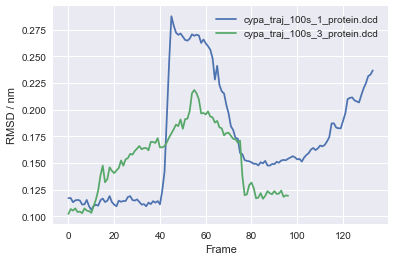

In [3]:
rmsds = [] 
for traj in vr_trajs: 
    rmsds.append(md.rmsd(traj, native_top))
    
fig = plt.figure()
for rmsd, file in zip(rmsds, filenames):
    plt.plot(rmsd, label=file)
plt.legend()
plt.xlabel("Frame")
plt.ylabel("RMSD / nm")
plt.show()

These trajectories are of users trying to move the loop defined by residues 100-110 towards residues 67-75. Residues 100-110 start near residues 80-90, so we can look at the distances between these key residues 

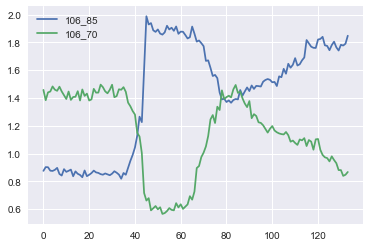

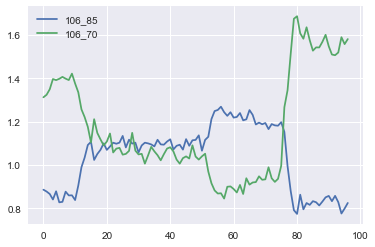

In [4]:
import itertools
#100s
contacts_res = [[106, 85],[106,70]]
#70s 
#contacts_res = list(itertools.product([72], [59]))
#print(contact_res)
for traj in vr_trajs:
    distances, pairs = md.compute_contacts(traj, contacts=contacts_res)
    distances = np.array(distances)
    
    fig = plt.figure()
    for i in range(len(pairs)):
        plt.plot(distances[:,i], label=str.format("{0}_{1}",pairs[i][0], pairs[i][1]))
    plt.legend()
    

In the first trajectory, the loop is brought close to residue 70, away again and back. In the second trajectory, the loop is not brought so close, but it seems to have been deposited back very near to the original state

In [5]:
nv.show_mdtraj(vr_trajs[1])

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


To quantify how close to the native state the secondary trajectory gets, we can compute the fraction of native contacts over the course of the trajectory:

In [6]:
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = md.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = md.compute_distances(traj, native_contacts)
    # and recompute them for just the native state
    r0 = md.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q  

Number of native contacts 2335


/Users/Mike/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: overflow encountered in exp


Number of native contacts 2291


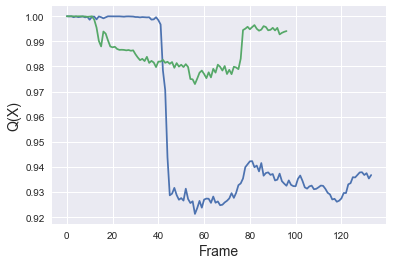

In [7]:
fig = plt.figure()
traj_q = []
for traj in vr_trajs: 
    q = best_hummer_q(traj, traj[0])
    traj_q.append(q)
    plt.plot(q)
    plt.xlabel('Frame', fontsize=14)
    plt.ylabel('Q(X)', fontsize=14)

plt.show()

From these we can see that the second trajectory (in green) does indeed return to something close to the native state, while the other trajectory is off in the weeds. 

## PCA Analysis

Let's see if we can use PCA to identify what's going on in these trajectories. We know roughly what sets of distances are important, so we'll use those contacts as the features (this could be scraped from the logging what the user does in VR). 

In [21]:
from sklearn.decomposition import PCA
traj = md.join(vr_trajs)
print(traj.n_frames)

231


In [9]:
#Residue pairs important in 100s loop movement
contacts_res = list(itertools.product([67+x for x in range(8)], [100+x for x in range(10)]))
contacts_res += list(itertools.product([80+x for x in range(10)], [100+x for x in range(10)]))
contacts_res += list(itertools.product([80+x for x in range(10)], [67+x for x in range(10)]))


(231, 280) (280, 2)


Text(0.5,1,'Contacts PCA')

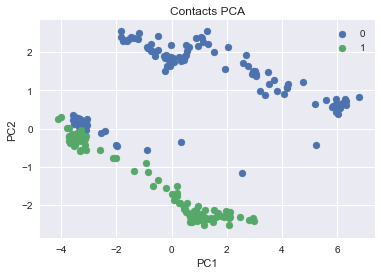

In [10]:
pca2 = PCA(n_components=2)

pairwise_distances, pairs = md.compute_contacts(traj, contacts_res, scheme='closest')
print(pairwise_distances.shape, pairs.shape)
reduced_distances = pca2.fit_transform(pairwise_distances)
plt.figure()

min_index = 0 
max_index = 1
for i, vr_traj in zip(range(len(vr_trajs)),vr_trajs):
    max_index += vr_traj.n_frames -1
    plt.scatter(reduced_distances[min_index:max_index,0], reduced_distances[min_index:max_index,1], label=str(i))
    min_index += vr_traj.n_frames

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('Contacts PCA')

The two trajectories are quite clearly distinct, with the blue one covering a wider variance, while the green trajectory goes back and forth in a smaller space

## PCF Analysis For Feature Selection

We would like to know which distances are important based on the PCA. Based on this [stack overflow](https://stats.stackexchange.com/questions/108743/methods-in-r-or-python-to-perform-feature-selection-in-unsupervised-learning) answer, which is based on this [paper](http://venom.cs.utsa.edu/dmz/techrep/2007/CS-TR-2007-011.pdf) we select features. Features are selected by clustering features onto PCA components, and sorting them by cluster distance. 

In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features, n_init=10).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

Relevant residue pairs:
[[ 68 101]
 [ 88 106]
 [ 89 100]]


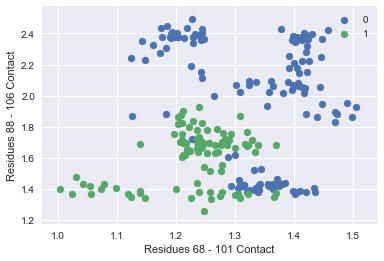

In [12]:
n_features = 3
pfa = PFA(n_features)
pfa.fit(pairwise_distances)

#get the feature labels 
reduced_pairs = pairs[pfa.indices_]
print("Relevant residue pairs:")
print(reduced_pairs)
#get the feature values
reduced_features = pairwise_distances[:,pfa.indices_]
fig = plt.figure()

min_index = 0
max_index = 0
for i, vr_traj in zip(range(len(vr_trajs)),vr_trajs):
    max_index += vr_traj.n_frames -1
    plt.scatter(reduced_features[min_index:max_index,0], reduced_features[min_index:max_index,1], label = i)
    min_index += vr_traj.n_frames
plt.xlabel(str.format("Residues {0} - {1} Contact",reduced_pairs[0][0], reduced_pairs[0][1]))
plt.ylabel(str.format("Residues {0} - {1} Contact",reduced_pairs[1][0], reduced_pairs[1][1]))
plt.legend()

Note that we get a different set of features every time we run this. I think this means the features are degenerate when projected onto the reduced dimensionality produced by PCA. Either distance between 80s and 100s increases, 70s to 100s decreases, 70s to 80s increases a bit, or some combination of them. The 3d view of 3 features shows a nice spread of the sampled motions:

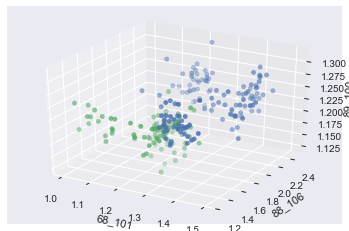

In [13]:
if n_features == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    min_index = 0
    max_index = 0
    for traj in vr_trajs:
        max_index += traj.n_frames
        ax.scatter(reduced_features[min_index:max_index,0], reduced_features[min_index:max_index,1],reduced_features[min_index:max_index,2])
        min_index += traj.n_frames
    ax.set_xlabel(str.format("{0}_{1}",reduced_pairs[0][0], reduced_pairs[0][1]))
    ax.set_ylabel(str.format("{0}_{1}",reduced_pairs[1][0], reduced_pairs[1][1]))
    ax.set_zlabel(str.format("{0}_{1}",reduced_pairs[2][0], reduced_pairs[2][1]))

In [24]:
traj = md.join(vr_trajs)
print(traj.n_frames)

231


Same thing, but with distances between all residues

In [23]:
pca2 = PCA(n_components=2)

pairwise_distances, pairs = md.compute_contacts(traj,'all', scheme='closest')
print(pairwise_distances.shape, pairs.shape)

(231, 13203) (13203, 2)


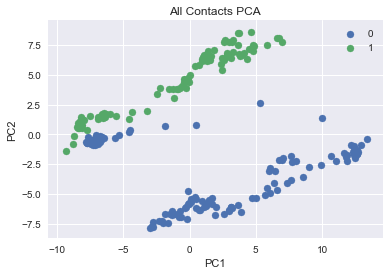

In [25]:
reduced_distances = pca2.fit_transform(pairwise_distances)
plt.figure()

min_index = 0 
max_index = 1
for i, vr_traj in zip(range(len(vr_trajs)),vr_trajs):
    max_index += vr_traj.n_frames -1
    plt.scatter(reduced_distances[min_index:max_index,0], reduced_distances[min_index:max_index,1], label=str(i))
    min_index += vr_traj.n_frames

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('All Contacts PCA')
plt.show()

Relevant residue pairs:
[[ 37 118]
 [ 85 105]
 [108 163]]


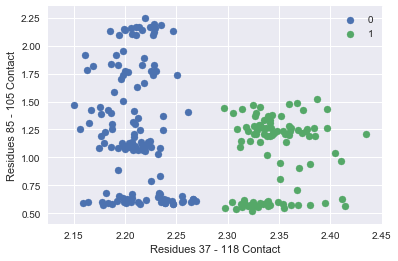

In [26]:
n_features = 3
pfa = PFA(n_features)
pfa.fit(pairwise_distances)

#get the feature labels 
reduced_pairs = pairs[pfa.indices_]
print("Relevant residue pairs:")
print(reduced_pairs)
#get the feature values
reduced_features = pairwise_distances[:,pfa.indices_]
fig = plt.figure()

min_index = 0
max_index = 0
for i, vr_traj in zip(range(len(vr_trajs)),vr_trajs):
    max_index += vr_traj.n_frames -1
    plt.scatter(reduced_features[min_index:max_index,0], reduced_features[min_index:max_index,1], label = i)
    min_index += vr_traj.n_frames
plt.xlabel(str.format("Residues {0} - {1} Contact",reduced_pairs[0][0], reduced_pairs[0][1]))
plt.ylabel(str.format("Residues {0} - {1} Contact",reduced_pairs[1][0], reduced_pairs[1][1]))
plt.legend()

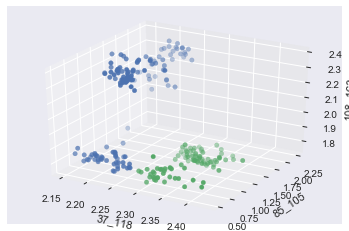

In [27]:
if n_features == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    min_index = 0
    max_index = 0
    for traj in vr_trajs:
        max_index += traj.n_frames
        ax.scatter(reduced_features[min_index:max_index,0], reduced_features[min_index:max_index,1],reduced_features[min_index:max_index,2])
        min_index += traj.n_frames
    ax.set_xlabel(str.format("{0}_{1}",reduced_pairs[0][0], reduced_pairs[0][1]))
    ax.set_ylabel(str.format("{0}_{1}",reduced_pairs[1][0], reduced_pairs[1][1]))
    ax.set_zlabel(str.format("{0}_{1}",reduced_pairs[2][0], reduced_pairs[2][1]))

With all contacts, an additional difference between the two trajectories is picked up, they are in slightly different configurations at all times as can be observed by the 37-118 contact. This time, the 108 - 163 distance is picked out as one of the distances that increases as well as the 85-105 distance. In the protein, the 163rd residue is effectively just further away than the 80s residues.